<a href="https://colab.research.google.com/github/amkobee/ADS/blob/main/ADS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [13]:
import random
import urllib.request
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import requests
import zipfile
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Dataset creation
Downloading the photos from Flickr and downloading the photos as a zip. <br>
The images are being downloaded via the FlickrAPI and stored in seperate folders for each class. In order to do that the user must create a public and secret key as described on the Flickr website https://www.flickr.com/services/apps/create/apply/. Add the new values to `FLICKR_PUBLIC` and `FLICKR_SECRET`<br>
The images are stored on GitHub - due to GitHub file size limitations we were only able to store a total of 100 MB. We decided to store around 5000 images with FlickrAPI size "s". <br>
In order to run the function the variable `download_new_photos` must be set to `True`. Additional keywords/classes can be introduced as well and the amount of photos to download can be changed in the variable `TOTAL_PHOTOS`

In [14]:
# set to False to not download new photos
download_new_photos = False

# the keywords to look photos for
keywords = ['sea', 'desert', 'mountain', 'river', 'forest']

# Function to download pictures from Flickr

def download_photos():

    # install and import FlickrAPI package
    !pip install flickrapi
    from flickrapi import FlickrAPI

    # Keys for flickr API
    FLICKR_PUBLIC = '5829447acb20544b640f7c58b058614a'
    FLICKR_SECRET = '856705a9f309b147'

    # Settings (extras = different resolution of photos)
    flickr = FlickrAPI(FLICKR_PUBLIC, FLICKR_SECRET, format='parsed-json')
    extras = 'url_s'

    # how many photos per category
    TOTAL_PHOTOS = 2000
    PHOTOS_PER_PAGE = 500

    cwd = os.getcwd()
    print(f'Photos will be stored at: {cwd}')

    # create photos directory
    try:
        os.mkdir('photos')
        print('Created folder photos')
    except:
        print('Folder "photos" already exists')

    # download the photos per keyword
    for word in keywords:
        # get all photos of the category
        page = 1
        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)

        # create subfolders
        try:
            os.mkdir('photos/'+word)
            print('Created folder ' + word)
        except:
            print(f'Folder "{word}" already exists')

        # download the photos
        j = 1 # index for filenames - won't be reset
        filename = ''
        batch = 1
        total_batch = int(TOTAL_PHOTOS/100)

        while j <= TOTAL_PHOTOS:
            i = random.randint(1, PHOTOS_PER_PAGE-1)
            try:
                url = photos['photos']['photo'][i]['url_s']
            except:
                try:
                  error_photo = photos['photos']['photo'][i]
                  print(f'Error at {error_photo}')
                except:
                  pass

            filename = 'photo_' + str(j) + '.jpg'
            directory = 'photos/' + word + "/" + filename
            urllib.request.urlretrieve(url, directory)
            #print(f'Category {word}: Page {page}; Downloading {j} of {TOTAL_PHOTOS}')
            if j % 100 == 0:
                print(f'Batch {batch} of {total_batch} done')
                batch += 1
            j += 1

            # reached end of page - reset i and increase page
            if j % 500 == 0:
                page += 1
                print('Reached end of page')
                photos = flickr.photos.search(text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)


    print('Finished downloading the photos')
    
    # store all in zip and download
    print('Creating zip file and downloading it')
    !zip -r /content/photos/photos.zip /content/photos
    from google.colab import files
    files.download("/content/photos/photos.zip")

if download_new_photos:
    download_photos()

# Data Exploration
Retrieving the data from GitHub and retrieving example images of the dataset

In [4]:
# Download zip file from GitHub
url = 'https://github.com/amkobee/ADS/raw/main/photos.zip'
r = requests.get(url, allow_redirects=True)

open('photos.zip', 'wb').write(r.content)

# Unzip the file
with zipfile.ZipFile('photos.zip', 'r') as zip_ref:
    zip_ref.extractall()            # folder named "content" will be created

In [5]:
# get the amount of photos
data_dir = '/content/content/photos/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5000


In [7]:
# create a dataset containing all information

batch_size = 32
img_height = 180
img_width = 180

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# get the class names from the folder names
class_names = full_ds.class_names
print(class_names)

Found 5000 files belonging to 5 classes.
['desert', 'forest', 'mountain', 'river', 'sea']


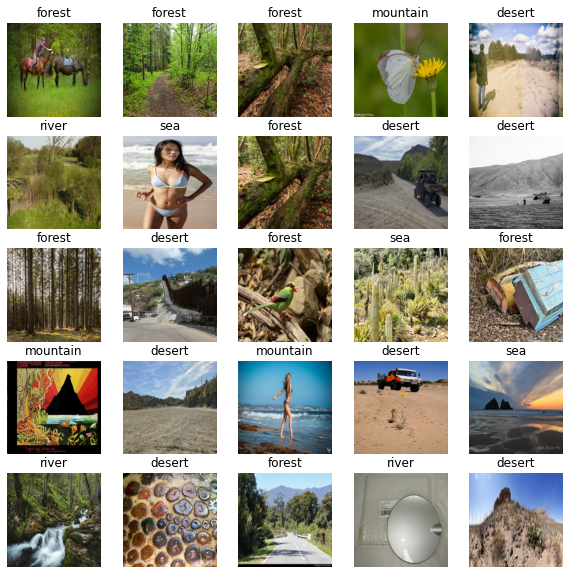

In [8]:
# print some example images
plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Result Discussion

Retrieving the images from a platform where everyone can upload their on images with own tags and descriptions can lead to bad data for our model. <br>
In order to mitigate that risk we introduced randomnes to our fetching function. <br>
With that we want to avoid bad data on one handside on the other we don't want to use mulitple pictures of the same object/landscape uploaded by the same user.

# Data Preparation

In [9]:
# split in training and test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


# Model Creation and Training

Below we will show different iterations of our models <br>
The first model shows our initial setup. The following will show all the modifications that were made during the process

## First training

In [16]:
# set amount of classes to amount of keywords
num_classes = len(keywords)

# define the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [17]:
# Train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/20
125/125 [==============================] - 14s 108ms/step - loss: 1.6229 - accuracy: 0.2892 - val_loss: 1.4289 - val_accuracy: 0.3760
Epoch 2/20
125/125 [==============================] - 12s 98ms/step - loss: 1.2501 - accuracy: 0.5033 - val_loss: 1.1666 - val_accuracy: 0.5470
Epoch 3/20
125/125 [==============================] - 13s 100ms/step - loss: 0.9294 - accuracy: 0.6680 - val_loss: 1.0180 - val_accuracy: 0.6250
Epoch 4/20
125/125 [==============================] - 13s 98ms/step - loss: 0.6468 - accuracy: 0.7755 - val_loss: 1.0082 - val_accuracy: 0.7140
Epoch 5/20
125/125 [==============================] - 12s 95ms/step - loss: 0.4302 - accuracy: 0.8628 - val_loss: 1.0705 - val_accuracy: 0.7270
Epoch 6/20
125/125 [==============================] - 12s 96ms/step - loss: 0.3002 - accuracy: 0.9101 - val_loss: 1.1429 - val_accuracy: 0.7320
Epoch 7/20
125/125 [==============================] - 13s 100ms/step - loss: 0.2313 - accuracy: 0.9332 - val_loss: 1.4115 - val_accura

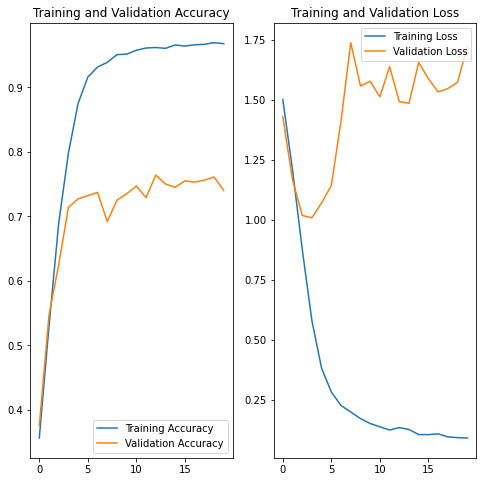

In [18]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Result Discussion

We reached quite a good result on the first try with the training data set. <br>
In accuracy the model performs approx. 20-25% worse with the validation data set. Additionally the difference in loss is extremely high compared to the trainig data set <br>
In order to improve the result for the validation data set we'll introduce dropout to the model in the next iteration.

## Second training

Added dropout

# Model testing

In [ ]:
# Scrape pictures and classify

